<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/llamaindex/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval for Wikipedia Articles
Reference: [Notebook link](https://github.com/run-llama/llama_index/blob/main/docs/examples/multi_modal/multi_modal_retrieval.ipynb) from LlamaIndex & [Blog post](https://medium.com/gitconnected/multimodal-retrieval-with-text-embedding-and-clip-image-embedding-for-backyard-birds-599f19057a70) from Wenqi Glantz.



Let's build a Multi-Modal retrieval system using LlamaIndex.

1. OpenAI CLIP model `ViT-B/32` for image embeddings.
2. `BAAI/bge-base-en-v1.5` for text embeddings. (Instead of OpenAI embeddiings) [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
3. `gpt-3.5-turbo` as LLM for text response synthesizing.


Steps:
1. Download texts and images raw files from Wikipedia articles.
2. Index the text using `BAAI/bge-base-en-v1.5` embeddings.
3. Index the images using OpenAI [CLIP](https://github.com/openai/CLIP) embeddings.
5. Both the text and image embeddings are stored as separate collection in [Qdrant](https://qdrant.tech/).
4. During query, retrieve both text and images.

**CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs**

In [1]:
%%capture
!pip install llama_index ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!pip install matplotlib scikit-image
!pip install -U qdrant_client

## Load and Download Multi-Modal datasets including texts and images from Wikipedia
Parse wikipedia articles and save into local folder

In [2]:
from pathlib import Path
import requests

wiki_titles = [
    "Kathmandu",
    "Helsinki",
    "iPhone",
    "Tesla Model S"
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [3]:
#!rm -rf /content/data_wiki/

In [4]:
import os
# https://platform.openai.com/account/api-keys

os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

## Build text index for Vector Store and define the text query engine

In [5]:
%%capture
!pip install transformers

In [6]:
import qdrant_client
from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.llms import OpenAI

# create QdrantClient with the location set to ":memory:", which means the vector db will be stored in memory
text_client = qdrant_client.QdrantClient(location=":memory:")

# load Text documents from the data_wiki directory
text_documents = SimpleDirectoryReader("./data_wiki").load_data()

# define llm and embedding model in ServiceContext
service_context = ServiceContext.from_defaults(
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-base-en-v1.5" # downloads the embedding model to my Colab notebook
)

# create QdrantVectorStore using QdrantClient and the collection name "widipedia_text"
text_vector_store = QdrantVectorStore(
    client=text_client, collection_name="wikipedia_text"
)

# create StorageContext object using the QdrantVectorStore
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)

# create VectorStoreIndex using the text documents and StorageContext
wiki_text_index = VectorStoreIndex.from_documents(
    text_documents,
    storage_context=storage_context,
    service_context=service_context
)

# define the text query engine
text_query_engine = wiki_text_index.as_query_engine()

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
len(text_documents)

4

In [27]:
%ls /tmp/llama_index

models/  tokenizers/


In [28]:
%ls /tmp/llama_index/models/

models--BAAI--bge-base-en-v1.5/


In [29]:
%ls /tmp/llama_index/tokenizers/

punkt/  punkt.zip


## Build image index for vector store using OpenAI CLIP embeddings

### Load and initialize CLIP model

In [8]:
import torch
import clip
import numpy as np

model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 36.2MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [9]:
%%capture
!pip install wikipedia

### Download and store images from Wiki pages

In [10]:
import wikipedia
import urllib.request

image_path = Path("images_wiki")
image_uuid = 0

# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = [
    "Kathmandu",
    "Helsinki",
    "iPhone",
    "Tesla Model S"
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        # raise Exception("No page found")
        continue

Kathmandu
Helsinki
iPhone
Tesla Model S


### Show downloaded Images from Wikipedia

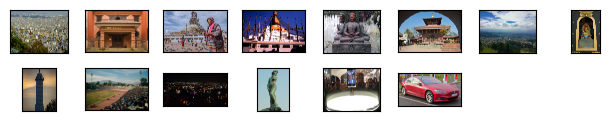

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Generate Clip embedding for each each image

In [12]:
# set the device to use for the CLIP model, either CUDA (GPU) or CPU, depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)
print(clip.available_models())

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}
with torch.no_grad():

    # iterate over the image metadata dictionary and extracts image embeddings for each image
    for image_id in image_metadata_dict:
        img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 2
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )

            # extract image features using the CLIP model's encode_image function
            image_features = model.encode_image(image)

            # store the image features in the image embedding dictionary
            img_emb_dict[image_id] = image_features

cpu
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [13]:
len(img_emb_dict) #22 image so 22 img emb

14

### Build a separate CLIP image embedding index under a differnt collection `wikipedia_img`

In [14]:
from llama_index.schema import ImageDocument

# create a list of ImageDocument objects, one for each image in the dataset
img_documents = []
for image_filename in image_metadata_dict:
    # the img_emb_dict dictionary contains the image embeddings
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]
        #print(filepath)

        # create an ImageDocument for each image
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )

        # set image embedding on the ImageDocument
        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

# create QdrantVectorStore, with collection name "wikipedia_img"
image_vector_store = QdrantVectorStore(
    client=text_client, collection_name="wikipedia_img"
)

# define storage context
storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

# define image index
image_index = VectorStoreIndex.from_documents(
    img_documents,
    storage_context=storage_context
)

### Function for image query

- `retrieve_results_from_image_index` takes a text query as input and returns the most similar image from the vector store.
- `plot_image_retrieval_results` takes a list of image retrieval results and creates a new figure.
- `image_query` is a wrapper function to call the two functions above.

In [21]:
from llama_index.vector_stores import VectorStoreQuery


def retrieve_results_from_image_index(query):
    """ take a text query as input and return the most similar image from the vector store """

    # first tokenize the text query and convert it to a tensor
    text = clip.tokenize(query).to(device)

    # encode the text tensor using the CLIP model to produce a query embedding
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1, # returns 1 image
        mode="default",
    )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results


In [22]:
def plot_image_retrieve_results(image_retrieval_results):
    """ take a list of image retrieval results and create a new figure"""

    plt.figure(figsize=(16, 5))

    img_cnt = 0

    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.

    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [23]:
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    plot_image_retrieve_results(image_retrieval_results)

## Get MultiModal retrieval results (both text and images) for some example queries

Text retrieval results: 
Some of the historical places in Kathmandu include Kathmandu Durbar Square, Patan Durbar Square, Bhaktapur Durbar Square, the former durbar of Kirtipur, Nyatapola, Kumbheshwar, the Krishna temple, and others.


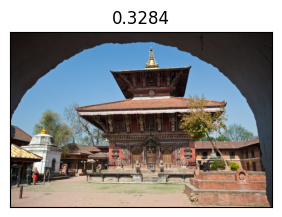

In [24]:
# https://en.wikipedia.org/wiki/Kathmandu
query1 = "What are some of the historical places in Kathmandu?"
# generate image retrieval results
image_query(query1)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query1)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
Some of the popular tourist attractions in Helsinki include Suomenlinna (Sveaborg) fortress, Korkeasaari Zoo, Seurasaari island, Lauttasaari island, and the Helsinki Central Park.


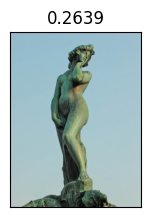

In [25]:
# https://en.wikipedia.org/wiki/Helsinki
query2 = "What are some of the popular tourist attraction in Helsinki?"
# generate image retrieval results
image_query(query2)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query2)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
Tesla, Inc. makes Tesla vehicles.


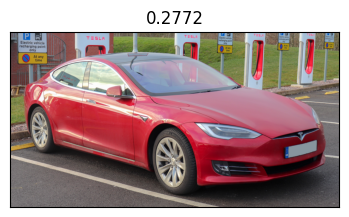

In [26]:
# https://en.wikipedia.org/wiki/Tesla_Model_S
query3 = "which company makes Tesla ?"
# generate image retrieval results
image_query(query3)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query3)
print("Text retrieval results: \n" + str(text_retrieval_results))

## Happy Retrieving 😎